## Air quality analysis and prediction

The project was performed as an assigment in Machine Learning and Artificial Intelligence course at the University of Sheffield. <br>The dataset is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality). 

The target variable corresponds to the first column CO(GT) variable. 
<br> The roadmap of the project: 
1. data preprocessing, 
2. model training
3. testing and validation. 

Testing data for validation is set aside before any preprocessing. 

### Data preprocessing

* Split the data into training and testing sets 
* Remove the rows with missing target (for supervised learning, all the targets should be known) 
* Remove features with more than 20% of missing values. 
* Replace all the other missing values with the mean value of the non-missing values for imputation.
* Normalise the data by substracting the mean value for each feature and dividing the result by the standard deviation of each feature

Normalisation puts all feature values in one range which speeds up convergence of different algorithms for finding of optimal parameters of a model. 
### Model validation
* Perform similar data preprocessing for the test data:
- Remove the rows of the test data for which the labels have missing values. 
- Remove the same features that were removed for the train data
- Replace the missing values on each feature variables with the mean values computed for the training data.
* Normalise the test data using the means and standard deviations computed from the training data
* Compute again $\mathbf{w}$ for the value of $\alpha$ that best performed on the validation set using ALL the training data (not all the training set).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd 

import pods
import zipfile
SEED = 5791

In [2]:
pods.util.download_url('https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip')

zip = zipfile.ZipFile('./AirQualityUCI.zip', 'r')
for name in zip.namelist():
    zip.extract(name, '.')

[===========================   ]   1.328/1.472MB

[==============================]   1.472/1.472MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


In [3]:
# The .csv version of the file has some typing issues, therefore the excel version is used
air_quality = pd.read_excel('AirQualityUCI.xlsx', usecols=range(2,15))

In [4]:
air_quality.sample(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
573,-200.0,1331.000000,-200,11.896096,1046.00,-200.0,882.250000,-200.0,1634.750000,904.50,24.975000,27.500000,0.857509
652,1.3,1026.500000,152,5.908036,807.50,76.0,996.250000,81.0,1457.750000,647.00,15.775000,48.625000,0.865316
3114,0.4,929.666667,-200,4.224369,723.00,43.0,1034.666667,62.0,1263.333333,474.00,37.866666,15.033333,0.972838
4217,-200.0,1156.250000,-200,14.329123,1127.25,-200.0,615.500000,-200.0,1767.250000,1294.50,34.075000,28.750000,1.510525
3699,1.5,1067.750000,-200,8.425123,916.50,70.0,735.500000,59.0,1727.500000,915.75,30.850000,45.025000,1.973313


In [5]:
np.random.seed(SEED)

# Shuffle indexes and then select first 70% for train set
indexes = np.random.permutation(air_quality.index)
train_size = int(air_quality.shape[0]*0.7)
indexes_train = indexes[0:train_size]
indexes_test = indexes[train_size:]

air_quality_train = air_quality.iloc[indexes_train, :]
air_quality_test = air_quality.iloc[indexes_test, :]

# Checking shapes
print('Train set:',air_quality_train.shape[0], 'Test:', air_quality_test.shape[0])
print('Train set share:', round(air_quality_train.shape[0]/air_quality.shape[0], 3))
print('Train + test == all set:',(air_quality_train.shape[0]+air_quality_test.shape[0])==air_quality.shape[0])

Train set: 6549 Test: 2808
Train set share: 0.7
Train + test == all set: True


In [6]:
air_quality_test.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
588,-200.0,1073.50,-200,4.378100,731.25,-200.0,1019.75,-200.0,1487.75,890.75,12.925,69.125000,1.026384
5680,4.4,1380.75,-200,23.621526,1393.75,560.0,494.50,107.0,1911.00,1557.50,20.600,60.150001,1.442803
5970,0.6,704.75,-200,1.091553,508.00,93.0,1493.50,54.0,820.00,329.25,12.375,31.975000,0.458277
963,-200.0,930.00,-200,4.639503,745.00,-200.0,1084.75,-200.0,1390.75,712.25,10.775,68.150002,0.880582
1106,2.5,1084.75,204,8.184613,906.75,133.0,975.75,101.0,1418.75,893.00,16.575,33.950001,0.635259


## Exploratory analysis and first Data preprocessing

In [7]:
# Exploratory analysis
print('Percent of missing values in row data')
for col in air_quality_train.columns:
    percent_missing = round(air_quality_train[air_quality_train[col]== -200].shape[0]*100/
                                                          air_quality_train.shape[0], 1)
    print(col, ':',percent_missing )

# Dropping rows with missing target values

rows_missing_target = air_quality_train[air_quality_train['CO(GT)']==-200].index
print('Removing', len(rows_missing_target),'rows with missing target values...')
air_quality_train.drop(rows_missing_target, axis=0, inplace=True)

# Dropping feature columns with more than 20% of missing values and replacement of other missing values
print('')
print('Dealing with missing data...')
print('')
for col in air_quality_train.columns[1:]:
    percent_missing = round(air_quality_train[air_quality_train[col]== -200].shape[0]*100/
                                                          air_quality_train.shape[0], 1)
    if percent_missing >20:
        print('')
        print("!!!!!!! Removing column:", col, 'Percent of missing values',percent_missing )
        air_quality_train.drop(columns = col, axis=1, inplace = True)
        print('')
    else:
        indexes_missing_rows = air_quality_train[air_quality_train[col] == -200].index
        mean_value = air_quality_train[air_quality_train[col] != -200][col].mean()
        
        print('Replacing', percent_missing,'% missing values in', col, 'with mean value', mean_value)
        for row in indexes_missing_rows:
            air_quality_train.loc[row][col] = mean_value

Percent of missing values in row data
CO(GT) : 18.1
PT08.S1(CO) : 4.0
NMHC(GT) : 89.8
C6H6(GT) : 4.0
PT08.S2(NMHC) : 4.0
NOx(GT) : 17.4
PT08.S3(NOx) : 4.0
NO2(GT) : 17.4
PT08.S4(NO2) : 4.0
PT08.S5(O3) : 4.0
T : 4.0
RH : 4.0
AH : 4.0
Removing 1188 rows with missing target values...

Dealing with missing data...

Replacing 4.5 % missing values in PT08.S1(CO) with mean value 1111.6980082015232

!!!!!!! Removing column: NMHC(GT) Percent of missing values 88.0

Replacing 4.5 % missing values in C6H6(GT) with mean value 10.32424319492447
Replacing 4.5 % missing values in PT08.S2(NMHC) with mean value 948.7096758445616
Replacing 5.2 % missing values in NOx(GT) with mean value 255.50877779964577
Replacing 4.5 % missing values in PT08.S3(NOx) with mean value 826.5708683199895
Replacing 5.3 % missing values in NO2(GT) with mean value 114.68328081922016
Replacing 4.5 % missing values in PT08.S4(NO2) with mean value 1448.4118173533814
Replacing 4.5 % missing values in PT08.S5(O3) with mean value 1

In [8]:
# Checking C6H6(GT) column - percent of replaced values

air_quality_train[air_quality_train['C6H6(GT)']== 10.29892670134189].shape[0]*100/air_quality_train.shape[0]

0.0

### Normalising the  data 

In [9]:
means_and_deviations = {}
for col in air_quality_train.columns[1:]: # the target variable doesn't need normalisation
    col_mean = air_quality_train.loc[:, col].mean()
    col_std = air_quality_train.loc[:, col].std()
    means_and_deviations[col]= [col_mean, col_std]
    air_quality_train.loc[:, col] = (air_quality_train.loc[:,col] - col_mean)/col_std

In [10]:
# Checking ranges
print(air_quality_train['PT08.S1(CO)'].min(), air_quality_train['PT08.S1(CO)'].max())
print(air_quality_train['RH'].min(), air_quality_train['RH'].max())

-3.618467852332394 2.849702302457986
-2.334629601834667 2.232564887781821


## Training and validation stages

In [11]:
# make feature and target vectors
y = air_quality_train['CO(GT)'].values
x = air_quality_train.drop(columns = ['CO(GT)'], axis=1).copy().values
# X = np.hstack((np.ones_like(x), x))
X = np.hstack((np.ones([x.shape[0],1]), x))

y.shape, x.shape, X.shape

((5361,), (5361, 11), (5361, 12))

## Training with closed form expression for $\mathbf{w}$ 

In [12]:
# Shuffle indexes and then select first 70% for train2 set from original train set
np.random.seed(SEED)

indexes_train = np.random.permutation(air_quality_train.index)
train2_size = int(air_quality_train.shape[0]*0.7)
indexes_train2 = indexes_train[0:train2_size]
indexes_valid = indexes_train[train2_size:]

air_quality_train2 = air_quality_train.loc[indexes_train2, :]
air_quality_valid = air_quality_train.loc[indexes_valid, :]

y_train2 = air_quality_train2['CO(GT)'].values
x_train2 = air_quality_train2.drop(columns = ['CO(GT)'], axis=1).copy().values
X_train2 = np.hstack((np.ones([x_train2.shape[0],1]), x_train2))

y_valid = air_quality_valid['CO(GT)'].values
x_valid = air_quality_valid.drop(columns = ['CO(GT)'], axis=1).copy().values
X_valid = np.hstack((np.ones([x_valid.shape[0],1]), x_valid))

In [13]:
X_train2.shape, X_valid.shape

((3752, 12), (1609, 12))

**Equation for computing** $\mathbf{w}$: 
$
[2\mathbf{X}^\top \mathbf{X} + \alpha^{.} nI]\mathbf{w} = 2\mathbf{X}^\top \mathbf{y}
$

In [14]:
# create a set of values of regularisation parameter in log scale
alphas_range = np.logspace(start=-3, stop=2, num=20)

In [15]:
import scipy as sp
from scipy import linalg

n_train2 = len(y_train2)
mse_valid = 0
mse_alphas = []
for alpha in alphas_range:
    
    sum_matrices = 2*np.dot(X_train2.T, X_train2) + alpha * n_train2* np.identity(X_train2.shape[1])
    w = sp.linalg.solve(sum_matrices, 2*np.dot(X_train2.T, y_train2))   
    
    predicted_valid = np.dot(X_valid, w)
    error = (y_valid - predicted_valid )**2
    mse_valid = error.mean()
    mse_alphas.append(mse_valid)

# The best alpha:
best_alpha = alphas_range[mse_alphas == np.array(mse_alphas).min()][0]
print('Minimum MSE for validation set among %s values is %s' %( len(mse_alphas), np.array(mse_alphas).min()))
print('The best alphas is %s' %(best_alpha))

Minimum MSE for validation set among 20 values is 0.24444187671688808
The best alphas is 0.02069138081114789


#### Conclusion

The best value of $\alpha $ is 0.001 in the range from 0.001 to 100 which is lowest value in the whole studied range.
<br>The regularisation term is primarily used to improve generalisation property of a model to deal with unknown data.  The low value of alpha decreases effect of regularisation and brings us back to a classic linear model. The fact that we have chosen such a low alpha from the results of the model implimentation onto validation set which had not been used before, let us assume that a simple linear regression could also perform rather good on the studied air_quality data without overfitting it.

### Validation with the closed form expression for $\mathbf{w}$ 

In [16]:
# Removing rows with missing targets
rows_missing_target_test = air_quality_test[air_quality_test['CO(GT)']==-200].index
print('Removing', len(rows_missing_target_test),'rows with missing target values...')
air_quality_test.drop(rows_missing_target_test, axis=0, inplace=True)

Removing 495 rows with missing target values...


In [17]:
# Remove the same feature from test data, i.e. NMHC(GT) feature column
print('Removing "NMHC(GT)" column from test data...')
air_quality_test.drop('NMHC(GT)', axis=1, inplace=True)

Removing "NMHC(GT)" column from test data...


In [18]:
# Replacing missing values with mean found for training data
print('Checking missing data in C6H6(GT):', air_quality_test[air_quality_test['C6H6(GT)']== -200].shape[0])
for col in air_quality_test.columns[1:]:
    indexes_missing_rows = air_quality_test[air_quality_test[col] == -200].index
    mean_value = means_and_deviations[col][0]
    air_quality_test.loc[indexes_missing_rows, col] = mean_value

Checking missing data in C6H6(GT): 90


In [19]:
# Checking replacement
print('Missing data:', air_quality_test[air_quality_test['C6H6(GT)']== -200].shape[0])
print('Replaced data:', air_quality_test[air_quality_test['C6H6(GT)']== 10.29892670134189].shape[0])

# Checking columns in train and test data
len(air_quality_test.columns), len(air_quality_train.columns)

Missing data: 0
Replaced data: 0


(12, 12)

In [20]:
# Normalizing test data
for col in air_quality_test.columns[1:]:
    col_mean = means_and_deviations[col][0]
    col_std = means_and_deviations[col][1]
    air_quality_test.loc[:,col] = (air_quality_test.loc[:,col] - col_mean)/col_std

In [21]:
y_train = air_quality_train['CO(GT)'].values
x_train = air_quality_train.drop(columns = ['CO(GT)'], axis=1).copy().values

y_test = air_quality_test['CO(GT)'].values
x_test = air_quality_test.drop(columns = ['CO(GT)'], axis=1).copy().values

X_train = np.hstack((np.ones([x_train.shape[0],1]), x_train))
X_test = np.hstack((np.ones([x_test.shape[0],1]), x_test))

# Computing w for the value of 𝛼 using ALL the training data = X_train (not all the training set X_train2)

# Linear regression with regularisation
n_train = len(y_train)
alpha = best_alpha

sum_matrices = 2*np.dot(X_train.T, X_train) + alpha * n_train* np.identity(X_train.shape[1])
w_train = sp.linalg.solve(sum_matrices, 2*np.dot(X_train.T, y_train)) 

predicted_test = np.dot(X_test, w_train)
abs_error_reg = abs(y_test - predicted_test)
error_test_reg = abs_error_reg**2
mse_test_reg = error_test_reg.mean()

# Linear regression without regularisation
w_non_reg = np.linalg.solve(np.dot(X_train.T, X_train), np.dot(X_train.T, y_train))

predicted_test_non_reg = np.dot(X_test, w_non_reg)
abs_error_non_reg = abs(y_test - predicted_test_non_reg)
error_test_non_reg = abs_error_non_reg**2
mse_test_non_reg = error_test_non_reg.mean()

print('MSE on the preprocessed test data: %.3f' % mse_test_reg)

MSE on the preprocessed test data: 0.244


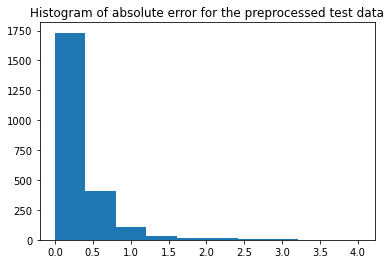

In [22]:
import pylab as plt
%matplotlib inline 

plt.hist(abs_error_reg, bins=10)
plt.title('Histogram of absolute error for the preprocessed test data');

In [23]:
print('Difference in MSE for models with regularisation and without it:', (mse_test_reg - mse_test_non_reg)*100/ mse_test_non_reg)

Difference in MSE for models with regularisation and without it: 0.08237850050176451


#### Conclusion
As it comes from our results, regularisation have led to a very little improvement of our model.
The best value of regularisation parameter which led to the lowest MSE values on validation set was found to be the lowest value in investigated range of alphas. In general, it means that our model might not need any regularisation at all. So it is not very surprising that the difference in MSE for models, trained on the whole train data with regularisation is just 0.08% better that the model without it.

## Training with gradient descent and validation 

#### Obective function : $ J(\mathbf{w}, \alpha) = \frac{1}n(Y - \mathbf{X}\mathbf{w})^{\top}(Y - \mathbf{X}\mathbf{w}) + \frac{\alpha}{2}\mathbf{w}^{\top} \mathbf{w} $

#### Update of $\mathbf{w}$ : $
\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} - \eta\frac{d J(\mathbf{w}, \alpha)}{d\mathbf{w}}= \mathbf{w}_{\text{old}}- \eta(-2\mathbf{X}(\mathbf{y} - \mathbf{X}\mathbf{w}) + \alpha^{.}\mathbf{w})
$

In [24]:
def SGD_minibatch(training_set, W, B = 100, learn_rate = 0.01, alpha=0.1, max_iter = 500, check_obj = 10):
    count_updates = 0
    obj_prev = None
    converge = False
    
    num_updates = []
    objectives = []
    
    indexes_train = np.random.permutation(training_set.index)
    indexes_minibatch = indexes_train[0:B]
    
    minibatch_train = training_set.loc[indexes_minibatch, :]
    
    for iteration in range(1,max_iter+1):
        #print('Iteration', iteration)
        if converge:
            break
        np.random.seed(SEED)
        np.random.shuffle(indexes_minibatch)
        for i in indexes_minibatch:
            if converge:
                break
            
            w = W.iloc[:,0].values
            x_i = np.hstack((1, minibatch_train.loc[i, features[1:]].values))
            y_i = minibatch_train.loc[i, target]

            # Computing gradient update
            pred = np.dot(x_i, w)
            diff = y_i - pred
            grad_w = -2*np.dot(x_i, diff) + alpha*w

            # In SGD, gradient and coefficients are udated for each sample, so I suppose n=1
            w_new = w - learn_rate*grad_w
            W.iloc[:,0]= w_new

            count_updates += 1
            # Checking objective function for each n_th = check_obj update
            if count_updates % check_obj == 0:
                f = y - np.dot(x_i, w_new) 
                obj = np.dot(f.T, f) + alpha/2 *np.dot(w_new.T, w_new)
                num_updates.append(count_updates)
                objectives.append(obj)
                print('After %s times updates, objective is %s'%(count_updates, obj))
                if obj_prev == None or (obj_prev - obj)/obj > 0.0001:
                    obj_prev = obj
                else:
                    converge = True
#     plt.plot(num_updates, objectives, 'ro-')
#     plt.title('Change of objective over updates')
#     plt.xlabel('Number of coefficients updates')
#     plt.ylabel('Objective for the current update')
#     plt.show();
#     print('Minimum objective:', np.array(objectives).min())
    return W  

In [25]:
# Testing SGD_minibatch function
target = 'CO(GT)'
features = ['w_0'] + air_quality_train2.columns[1:].to_list()
n_features = len(features)
np.random.seed(SEED)
W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns= ['w'])

SGD_minibatch(air_quality_train2, W, B=10, learn_rate=0.1778279410038923, alpha=0.001, 
              max_iter = 500, check_obj = 1000)

After 1000 times updates, objective is 1.425770125196176e+153
After 2000 times updates, objective is 1.0688605731323603e+300


,w
w_0,4.988896e+147
PT08.S1(CO),-3.756023e+146
C6H6(GT),2.892969e+146
PT08.S2(NMHC),9.465327e+145
NOx(GT),-8.875966e+146
PT08.S3(NOx),-1.731448e+145
NO2(GT),-3.025225e+146
PT08.S4(NO2),2.312465e+147
PT08.S5(O3),-4.908334e+146
T,3.174103e+147


In [26]:
%%time
# Because of the long range of alphas, running time is around 25 minutes
alphas_range = np.logspace(start=-3, stop=2, num=20)
learn_rate_range = np.logspace(start = -3, stop = 0, num = 5)
B_range = np.linspace(start = 10, stop = 1000, num = 5)

target = 'CO(GT)'
features = ['w_0'] + air_quality_train2.columns[1:].to_list()
n_features = len(features)
results = {}

for B in B_range:
    for learn_rate in learn_rate_range:
        for alpha in alphas_range:
            np.random.seed(SEED)
            W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns = ['w'] )
            
            # My training data  - air_quality_train (5353, 11), training set - air_quality_train2 (3747, 13)
            w_bacth = SGD_minibatch(air_quality_train2, W, int(B), learn_rate, alpha, 
                                    max_iter = 500, check_obj = 1000)
            
            # X_valid and y_valid were assigned in Question 6
            predicted_valid = np.dot(X_valid, w_bacth.iloc[:,0].values)
            abs_error_valid = abs(y_valid - predicted_valid)
            error_valid = abs_error_valid**2
            mse_valid = error_valid.mean()
            print('B = ',B, 'Learning rate = ', learn_rate, 'alpha =', alpha, 'MSE =', round(mse_valid, 5))
            print('=============')
            results[str(B)+',' +str(learn_rate)+',' +str(alpha)] = mse_valid

After 1000 times updates, objective is 33407.540553689236
After 2000 times updates, objective is 11478.969400493712
After 3000 times updates, objective is 14086.015391241113
B =  10.0 Learning rate =  0.001 alpha = 0.001 MSE = 0.57992
After 1000 times updates, objective is 33408.58958777506
After 2000 times updates, objective is 11479.145435085304
After 3000 times updates, objective is 14084.737947400885
B =  10.0 Learning rate =  0.001 alpha = 0.0018329807108324356 MSE = 0.58137
After 1000 times updates, objective is 33410.51126192836
After 2000 times updates, objective is 11479.483763948518
After 3000 times updates, objective is 14082.40982677329
B =  10.0 Learning rate =  0.001 alpha = 0.003359818286283781 MSE = 0.58403
After 1000 times updates, objective is 33414.02967601839
After 2000 times updates, objective is 11480.156279429537
After 3000 times updates, objective is 14078.187247943923
B =  10.0 Learning rate =  0.001 alpha = 0.006158482110660267 MSE = 0.58896
After 1000 times u

After 1000 times updates, objective is 26941.39152788032
After 2000 times updates, objective is 11523.789462096329
After 3000 times updates, objective is 14415.66257863793
B =  10.0 Learning rate =  0.005623413251903491 alpha = 0.12742749857031335 MSE = 0.49518
After 1000 times updates, objective is 28426.170950668482
After 2000 times updates, objective is 11490.954913470387
After 3000 times updates, objective is 14196.950730365123
B =  10.0 Learning rate =  0.005623413251903491 alpha = 0.23357214690901212 MSE = 0.77856
After 1000 times updates, objective is 30265.66352302394
After 2000 times updates, objective is 11812.469998641836
After 3000 times updates, objective is 14042.912659568017
B =  10.0 Learning rate =  0.005623413251903491 alpha = 0.42813323987193913 MSE = 1.37699
After 1000 times updates, objective is 32025.116204782327
After 2000 times updates, objective is 12794.423435112465
After 3000 times updates, objective is 14178.2751656955
B =  10.0 Learning rate =  0.0056234132

After 1000 times updates, objective is 54029.98908031536
After 2000 times updates, objective is 16304.230160297828
After 3000 times updates, objective is 24976.96595442997
B =  10.0 Learning rate =  0.03162277660168379 alpha = 29.763514416313193 MSE = 6.82222
After 1000 times updates, objective is 281253.6336918572
After 2000 times updates, objective is 11501.836196160464
After 3000 times updates, objective is 17132.246676650855
B =  10.0 Learning rate =  0.03162277660168379 alpha = 54.555947811685144 MSE = 7.03172
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  0.03162277660168379 alpha = 100.0 MSE = nan
After 1000 times updates, objective is 1.425770125196176e+153
After 2000 times updates, objective is 1.0688605731323603e+300
B =  10.0 Learning rate =  0.1778279410038923 alpha = 0.001 MSE = 7.29558673239725e+295
After 1000 times updates, objective is 1.3824292857486421e+153
After 2000 times updates, objective is 1.00206

After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  1.0 alpha = 29.763514416313193 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  1.0 alpha = 54.555947811685144 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  1.0 alpha = 100.0 MSE = nan
After 1000 times updates, objective is 20090.704617840423
After 2000 times updates, objective is 40657.054025387115
B =  257.5 Learning rate =  0.001 alpha = 0.001 MSE = 0.26203
After 1000 times updates, objective is 20081.387372472163
After 2000 times updates, objective is 40637.018305458645
B =  257.5 Learning rate =  0.001 alpha = 0.0018329807108324356 MSE = 0.26211
After 1000 times updates, objective is 20064.3314490806
After 2000 times updates, objective is 40600.33986198993
B =  257.5 Learning rate =  0.001 alpha = 0.003359818286283781 MSE

After 2000 times updates, objective is 11800.42330291691
After 3000 times updates, objective is 41684.6881008917
B =  257.5 Learning rate =  0.005623413251903491 alpha = 8.858667904100823 MSE = 3.64789
After 1000 times updates, objective is 22903.51204865345
After 2000 times updates, objective is 12079.522159474664
After 3000 times updates, objective is 43617.57605388998
B =  257.5 Learning rate =  0.005623413251903491 alpha = 16.23776739188721 MSE = 4.57863
After 1000 times updates, objective is 26292.462649388766
After 2000 times updates, objective is 15168.625410287128
After 3000 times updates, objective is 43106.31163940148
B =  257.5 Learning rate =  0.005623413251903491 alpha = 29.763514416313193 MSE = 5.30348
After 1000 times updates, objective is 27703.68576407192
After 2000 times updates, objective is 18276.640737622874
After 3000 times updates, objective is 40002.53284694293
B =  257.5 Learning rate =  0.005623413251903491 alpha = 54.555947811685144 MSE = 5.83321
After 1000 t

After 1000 times updates, objective is 5550511.4072076315
After 2000 times updates, objective is 1786011069963315.5
B =  257.5 Learning rate =  0.1778279410038923 alpha = 4.832930238571752 MSE = 79259373707.99127
After 1000 times updates, objective is inf
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  0.1778279410038923 alpha = 8.858667904100823 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  0.1778279410038923 alpha = 16.23776739188721 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  0.1778279410038923 alpha = 29.763514416313193 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  0.1778279410038923 alpha = 54.555947811685144 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rat

After 2000 times updates, objective is 35662.29015472969
B =  505.0 Learning rate =  0.001 alpha = 54.555947811685144 MSE = 6.06057
After 1000 times updates, objective is 33227.43386620468
After 2000 times updates, objective is 35254.9564747815
B =  505.0 Learning rate =  0.001 alpha = 100.0 MSE = 6.45209
After 1000 times updates, objective is 20581.123617845296
After 2000 times updates, objective is 19653.302527175376
After 3000 times updates, objective is 24783.93476723438
B =  505.0 Learning rate =  0.005623413251903491 alpha = 0.001 MSE = 0.24526
After 1000 times updates, objective is 20564.902161866554
After 2000 times updates, objective is 19652.34056695116
After 3000 times updates, objective is 24791.918218178223
B =  505.0 Learning rate =  0.005623413251903491 alpha = 0.0018329807108324356 MSE = 0.24523
After 1000 times updates, objective is 20535.259142758372
After 2000 times updates, objective is 19650.641794203268
After 3000 times updates, objective is 24806.5171705208
B =  

After 2000 times updates, objective is 20889.959702285556
B =  505.0 Learning rate =  0.03162277660168379 alpha = 4.832930238571752 MSE = 6.73495
After 1000 times updates, objective is 11561.789733305357
After 2000 times updates, objective is 22944.76870047938
B =  505.0 Learning rate =  0.03162277660168379 alpha = 8.858667904100823 MSE = 6.99021
After 1000 times updates, objective is 11483.294009475268
After 2000 times updates, objective is 24979.329548992228
B =  505.0 Learning rate =  0.03162277660168379 alpha = 16.23776739188721 MSE = 6.82488
After 1000 times updates, objective is 11747.757230907411
After 2000 times updates, objective is 28385.139013866592
B =  505.0 Learning rate =  0.03162277660168379 alpha = 29.763514416313193 MSE = 6.7693
After 1000 times updates, objective is 498919790775902.56
After 2000 times updates, objective is 6967616218344390.0
B =  505.0 Learning rate =  0.03162277660168379 alpha = 54.555947811685144 MSE = 1915538328400.9565
After 1000 times updates, o

After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  505.0 Learning rate =  1.0 alpha = 100.0 MSE = nan
After 1000 times updates, objective is 29708.975011493112
After 2000 times updates, objective is 18709.99478858268
After 3000 times updates, objective is 11849.846706033935
After 4000 times updates, objective is 11732.655814887488
After 5000 times updates, objective is 17140.264345079147
B =  752.5 Learning rate =  0.001 alpha = 0.001 MSE = 0.24444
After 1000 times updates, objective is 29714.742307725162
After 2000 times updates, objective is 18717.743415517296
After 3000 times updates, objective is 11847.90332007135
After 4000 times updates, objective is 11735.44429674141
After 5000 times updates, objective is 17146.535515898548
B =  752.5 Learning rate =  0.001 alpha = 0.0018329807108324356 MSE = 0.24449
After 1000 times updates, objective is 29725.30718311475
After 2000 times updates, objective is 18731.943041306866
After 3000 times updates, 

After 5000 times updates, objective is 16700.544650971708
B =  752.5 Learning rate =  0.005623413251903491 alpha = 0.011288378916846888 MSE = 0.25568
After 1000 times updates, objective is 25270.80792801132
After 2000 times updates, objective is 19949.41991462131
After 3000 times updates, objective is 11809.557976042106
After 4000 times updates, objective is 11674.983196684403
After 5000 times updates, objective is 16792.66895272821
B =  752.5 Learning rate =  0.005623413251903491 alpha = 0.02069138081114789 MSE = 0.25774
After 1000 times updates, objective is 25357.771092620842
After 2000 times updates, objective is 20034.43493725114
After 3000 times updates, objective is 11762.789152968518
After 4000 times updates, objective is 11753.723320992345
After 5000 times updates, objective is 16947.355712985685
B =  752.5 Learning rate =  0.005623413251903491 alpha = 0.0379269019073225 MSE = 0.26243
After 1000 times updates, objective is 25511.730728248906
After 2000 times updates, objective

After 2000 times updates, objective is 20175.34647136236
After 3000 times updates, objective is 11674.95914556813
After 4000 times updates, objective is 15502.564334686092
B =  752.5 Learning rate =  0.03162277660168379 alpha = 0.42813323987193913 MSE = 3.10658
After 1000 times updates, objective is 27340.077087448055
After 2000 times updates, objective is 20712.67678487963
After 3000 times updates, objective is 12016.7067076396
After 4000 times updates, objective is 17916.87727866158
B =  752.5 Learning rate =  0.03162277660168379 alpha = 0.7847599703514607 MSE = 3.60655
After 1000 times updates, objective is 28212.53170982689
After 2000 times updates, objective is 21917.673439881044
After 3000 times updates, objective is 12839.426979638918
After 4000 times updates, objective is 21746.73865205246
B =  752.5 Learning rate =  0.03162277660168379 alpha = 1.438449888287663 MSE = 4.34488
After 1000 times updates, objective is 29085.10398227196
After 2000 times updates, objective is 24056.5

After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  752.5 Learning rate =  1.0 alpha = 0.42813323987193913 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  752.5 Learning rate =  1.0 alpha = 0.7847599703514607 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  752.5 Learning rate =  1.0 alpha = 1.438449888287663 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  752.5 Learning rate =  1.0 alpha = 2.636650898730358 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  752.5 Learning rate =  1.0 alpha = 4.832930238571752 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  752.5 Learning rate =  1.0 alpha = 8.858667904100823 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, obje

After 1000 times updates, objective is 107029.77296719585
After 2000 times updates, objective is 12114.064087262906
After 3000 times updates, objective is 11823.852943749307
After 4000 times updates, objective is 15223.48540002289
B =  1000.0 Learning rate =  0.005623413251903491 alpha = 0.02069138081114789 MSE = 0.25204
After 1000 times updates, objective is 106220.50534051761
After 2000 times updates, objective is 12188.072744740071
After 3000 times updates, objective is 11889.42406521356
After 4000 times updates, objective is 15266.01179854716
B =  1000.0 Learning rate =  0.005623413251903491 alpha = 0.0379269019073225 MSE = 0.2525
After 1000 times updates, objective is 104792.15640190778
After 2000 times updates, objective is 12326.27740639798
After 3000 times updates, objective is 12018.145086673669
After 4000 times updates, objective is 15335.663929243367
B =  1000.0 Learning rate =  0.005623413251903491 alpha = 0.06951927961775606 MSE = 0.25523
After 1000 times updates, objectiv

After 1000 times updates, objective is 161244.85601058882
After 2000 times updates, objective is 16075.28853387614
After 3000 times updates, objective is 15961.486169656731
After 4000 times updates, objective is 18756.560300422083
B =  1000.0 Learning rate =  0.03162277660168379 alpha = 1.438449888287663 MSE = 2.08704
After 1000 times updates, objective is 90402.77226833062
After 2000 times updates, objective is 17955.250184883105
After 3000 times updates, objective is 19027.443067465818
B =  1000.0 Learning rate =  0.03162277660168379 alpha = 2.636650898730358 MSE = 4.12012
After 1000 times updates, objective is 15029.79864890819
After 2000 times updates, objective is 19496.6361427614
B =  1000.0 Learning rate =  0.03162277660168379 alpha = 4.832930238571752 MSE = 4.40806
After 1000 times updates, objective is 127609.46078703899
After 2000 times updates, objective is 20419.550743499098
After 3000 times updates, objective is 25900.870200702117
B =  1000.0 Learning rate =  0.03162277660

After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  1.0 alpha = 2.636650898730358 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  1.0 alpha = 4.832930238571752 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  1.0 alpha = 8.858667904100823 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  1.0 alpha = 16.23776739188721 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  1.0 alpha = 29.763514416313193 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  1.0 alpha = 54.555947811685144 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates,

In [27]:
# Our dictionary has np.nan and np.inf which we need to delete before sorting

sorted_results = pd.DataFrame(data= results.values(), index=results.keys(), columns = ['mse']).dropna()
inf_indexes = sorted_results[sorted_results.mse == np.inf].index
sorted_results.drop(inf_indexes, axis=0,inplace=True)
optimal_results = sorted_results.sort_values(['mse']).reset_index().iloc[0]

opt_B = int(float(optimal_results.iloc[0].split(',')[0]))
opt_learn_rate =  float(optimal_results.iloc[0].split(',')[1])
opt_alpha = float(optimal_results.iloc[0].split(',')[2])

print('Optimal B:', opt_B)
print('Optimal learning rate:',opt_learn_rate)
print('Optimal alpha:', opt_alpha)
print('Minimum MSE for validation set: %.4f' % optimal_results.iloc[1])

Optimal B: 752
Optimal learning rate: 0.001
Optimal alpha: 0.001
Minimum MSE for validation set: 0.2444


In [28]:
# Compare results with closed form solution
print('Minimum MSE for validation set for closed form solution is : %.4f' % (np.array(mse_alphas).min()))

Minimum MSE for validation set for closed form solution is : 0.2444


In [29]:
# Running minibatch SGD for the whole training data
np.random.seed(123)
W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns= ['w'])

w_train_bacth = SGD_minibatch(air_quality_train, W, B = opt_B, learn_rate=opt_learn_rate, alpha=0.001, max_iter = 500, check_obj = 1000)
predicted_test_batch = np.dot(X_test, w_train_bacth.iloc[:,0].values)
abs_error_test_batch = abs(y_test - predicted_test_batch)
error_test_batch = abs_error_test_batch**2
mse_test_batch = error_test_batch.mean()
print('MSE for test data from SGD on minibatch from all training data: %.4f' %  mse_test_batch)

After 1000 times updates, objective is 21105.60810247812
After 2000 times updates, objective is 15380.117944167012
After 3000 times updates, objective is 12664.785669266563
After 4000 times updates, objective is 30312.829828196365
MSE for test data from SGD on minibatch from all training data: 0.2505


In [30]:
# Result from closed form solution
print('MSE for test data from closed form solution for all training data: %.4f' %  mse_test_reg)

MSE for test data from closed form solution for all training data: 0.2438


In [31]:
# Diving more into learning rate investigation, we can found learn_rate = 0.00072 
# which gives results closer to those from closed form solution

np.random.seed(123)
W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns= ['w'])

w_train_bacth_2 = SGD_minibatch(air_quality_train, W, B = 1000, learn_rate= 0.00072, alpha=0.001, max_iter = 500, check_obj = 1000)
predicted_test_batch_2 = np.dot(X_test, w_train_bacth_2.iloc[:,0].values)
abs_error_test_batch_2 = abs(y_test - predicted_test_batch_2)
error_test_batch_2 = abs_error_test_batch_2**2
mse_test_batch_2 = error_test_batch_2.mean()
print('MSE for test data from SGD on minibatch from all training data: %.4f' %  mse_test_batch_2)

After 1000 times updates, objective is 20595.753451462842
After 2000 times updates, objective is 18419.67235128701
After 3000 times updates, objective is 13425.374813887054
After 4000 times updates, objective is 90092.57951952786
MSE for test data from SGD on minibatch from all training data: 0.2551


In [32]:
# w from closed form solution
w_train

array([ 2.13753874, -0.01158713,  0.57411908,  0.14298785,  0.4938014 ,
        0.0137199 ,  0.1235771 ,  0.43719377, -0.0816103 , -0.18969159,
       -0.06874104, -0.08622341])

In [33]:
# w from SGD minibatch
w_train_bacth['w'].values

array([ 2.14892354e+00, -5.59352858e-02,  4.59228709e-01,  3.23602119e-01,
        4.49681872e-01,  3.26217607e-02,  1.31864683e-01,  2.88730864e-01,
       -2.07737082e-03, -8.33151805e-02, -1.37868237e-02, -1.02379420e-01])

In [34]:
# w from SGD minibatch with improved learning rate
w_train_bacth_2['w'].values

array([ 2.15421806, -0.01952227,  0.43136846,  0.31918183,  0.43974188,
        0.00771079,  0.13671505,  0.27298384,  0.06562737, -0.06868111,
       -0.00925908, -0.08503417])

### Conclusion
Closed form solution computes parameters that correspond to a global minimum of objective function based on its mathematic essence, while minibatch solution deals with the iterative procedure of finding minimum and is in high risk of converging at a local minimum which will obviosly give worser results. 
<br>
Parameter 𝛼 appeared to be similar in both approaches. This can be a positive indicator of a proper work of our SGD and minibatch algorithm, as alpha had not been iteratively changed during computations in both approaches as it is a model hyperparameter which is assumed to be identical for the same models.  
<br>
In perfect case, the parameters 𝐰 should also be similar as they are used to describe one set of data with the same model. But they are not so in our case, and this can testify either need in more precise finding of algorithm hyperparameters (such as batch size and learning rate) to estimate global minimum corrrectly or convergence of minibatch algorithm at local minimum and not at global one.
<br> The manual case with improved learning rate shows more similarities in w for both approaches (MSE are 0.250 and 0.253), and that proves our idea of need in more precise estimation of algorithm hyperparameters.